In [1]:
import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt

In [2]:
from ast import literal_eval

In [3]:
scores_dir = 'scores'
segment_scores = 'issues/MAX_SCORES_segments_experimental_set_with_reference.xlsx'

In [3]:
scores_df = pd.read_excel(f'issues/df_for_transl_issues_df_SUM_REF_NER.xlsx')
scores_df.head(2)

,source,reference,mt,issues,wmt22-seqtag-mqm,corpus score,word_scores,NER_reference,NER_mt,sentence_num,issues_found
0,"I mean, describe to us this Bullrun program wh...","Расскажите нам о программе Bullrun, согласно к...","Я имею в виду, опишите нам эту программу Буллр...","addition, abbr",0.045041,-0.311334,"[('▁Я', 0.1389012187719345), ('▁имею', 0.16489...",АНБ,"Буллран, АНБ",1,"['Буллран,']"
1,We live in a world where GDP is the benchmark ...,"Мы живём в мире, где ВВП стал показателем успе...","Мы живем в мире, где GDP является эталоном усп...",abbr,0.579424,-0.311334,"[('▁Мы', 0.012581933289766312), ('▁живе', 0.00...",NaN,NaN,2,['GDP']


In [4]:
scores_df.shape

(371, 11)

In [12]:
types_of_issues = scores_df['issues'].str.split(', ', expand=True).stack()\
                                    .reset_index(level=1, drop=True).to_frame('issues')
types_of_issues_counts = types_of_issues.groupby('issues').size().reset_index(name='count')\
                            .sort_values(by='count', ascending=False)
types_of_issues_counts

,issues,count
4,other,177
2,gender,126
0,NE,104
3,mistr,49
1,Tone Of Voice,46
5,paraphrase,43


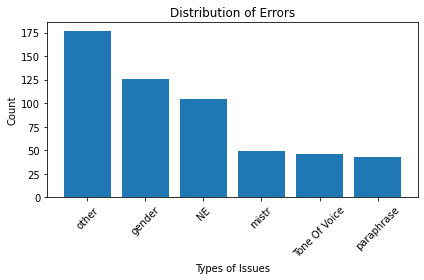

In [13]:
plt.bar(types_of_issues_counts['issues'], types_of_issues_counts['count'])

# Set the labels and title
plt.xlabel('Types of Issues')
plt.ylabel('Count')
plt.title('Distribution of Errors')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Adjust the layout to avoid overlapping labels
plt.tight_layout()

# Display the plot
plt.show()

### Add NER with Deeppavlov

In [32]:
segment_scores['issues'].fillna('', inplace=True)
segment_scores['NER_reference'].fillna('', inplace=True)
segment_scores['NER_mt'].fillna('', inplace=True)

In [33]:
issues_found = segment_scores['issues_found']
issues_found_list = []
for string in issues_found:
    issues_found_list.append(literal_eval(string))

In [34]:
# !pip install pymorphy2

In [35]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [36]:
morph.parse('АНБ')[0]

Parse(word='анб', tag=OpencorporaTag('UNKN'), normal_form='анб', score=1.0, methods_stack=((UnknAnalyzer(), 'АНБ'),))

In [37]:
issues_final_list = []
for issues in issues_found_list:
    issues_clean = []
    for issue in issues:
        issue = re.sub('[,"":;!?«»\(\)]', '', issue)
        issue = re.sub('\.$', '', issue)
        issues_clean.append(issue)
    issues_final_list.append(issues_clean)

In [38]:
segment_scores['issues_found'] = issues_final_list

#### Named entities

In [ ]:
!pip install --upgrade deeppavlov
!pip install torchcrf

In [ ]:
from deeppavlov import configs, build_model

In [ ]:
!git clone https://github.com/kmkurn/pytorch-crf.git

In [ ]:
os.chdir('/content/drive/MyDrive/диссер/pytorch-crf')

In [ ]:
!python setup.py install

In [ ]:
# Load the pre-trained DeepPavlov model
model_config = configs.ner.ner_rus_bert

In [ ]:
ner_model = build_model(model_config, download=True)

In [ ]:
# Process the text data using the NER model
def extract_ner(text):
   ner_result = ner_model([text])
   ners = []
   for word, ner in zip(ner_result[0][0], ner_result[1][0]):
    if ner != 'O':
      ners.append(word)
   return ', '.join(ners)

In [ ]:
segment_scores["NER_reference"] = segment_scores["reference"].apply(extract_ner)
segment_scores["NER_mt"] = segment_scores["mt"].apply(extract_ner)

In [ ]:
os.chdir('/content/drive/MyDrive/диссер')

In [ ]:
segment_scores.shape

In [39]:
ner_issues = []
for index, row in segment_scores.iterrows():
    ne = any(NE in row['issues_found'] for NE in row['NER_mt'].split(', '))
    if ne:
        ner_issues.append('yes')
    else:
        ner_issues.append('no')

In [40]:
segment_scores['NE_issues'] = ner_issues

In [44]:
ner_isses = segment_scores[(segment_scores['NE_issues']=='yes')]
ner_isses.shape

(81, 12)

In [45]:
ner_isses.to_excel('issues/issues_NER.xlsx', index=False)

#### Abbreviations

In [46]:
issues_abbr = segment_scores[(segment_scores['issues_found'].str.contains(r'[A-Z]+')) |
                               (segment_scores['issues_found'].str.contains(r'[А-Я]{4}'))]

In [47]:
abbreviations_regex = re.compile(r'[A-Z]{2,6}|[А-Я]{2,4}')

In [48]:
any([type(abbreviations_regex.search(x))==re.Match for x in ['GDP']])

True

In [49]:
abbr_issues = []
for index, row in segment_scores.iterrows():
    abbr = any([type(abbreviations_regex.search(x))==re.Match for x in row['issues_found']])
    if abbr:
        abbr_issues.append('yes')
    else:
        abbr_issues.append('no')

In [50]:
segment_scores['abbr_issues'] = abbr_issues

In [51]:
segment_scores[(segment_scores['abbr_issues']=='yes') &
              (segment_scores['issues'].str.contains('abbr'))].shape

(49, 13)

In [52]:
segment_scores[(segment_scores['abbr_issues']=='yes') &
              ~(segment_scores['issues'].str.contains('abbr'))]

,source,reference,mt,issues,wmt22-seqtag-mqm,corpus score,word_scores,NER_reference,NER_mt,sentence_num,issues_found,NE_issues,abbr_issues
77,"One way in particular attracted my attention, ...",Один из способов привлёк моё внимание. Он назы...,"Один способ особенно привлек мое внимание, и о...","gender, NE",-0.626813,-0.311334,"[('▁Один', 0.022774428129196167), ('▁способ', ...",Синтез,,84,"[она, слиянием, намагниченными, мишенями, MTF]",no,yes
131,"Lena Dunham, who's on here, her show on HBO th...","Лена Данхэм, чьё шоу «Девочки» открывается на ...","Лена Дунам, которая здесь, ее шоу на канале HB...","NE, other, mistr",-1.293286,-0.311334,"[('▁Ле', 0.2016839236021042), ('на', 0.1612027...","Лена, Данхэм, HBO","Лена, Дунам, HBO",155,"[Дунам, здесь, ее, HBO, месяце, Девочки, начат...",yes,yes
136,"And with this telescope, with this data, we've...","И с помощью этого телескопа, этих данных, мы с...","И с помощью этого телескопа, с этими данными, ...",NE,0.008848,-0.311334,"[('▁И', 0.01169497799128294), ('▁с', 0.0135798...",-,,160,"[Галактический, внегалактический, обзор, всего...",no,yes
137,There was a big competition for the design of ...,"Конечно, был большой конкурс за право проектир...","Был большой конкурс на проект этого моста, и п...","NE, other",-0.200574,-0.311334,"[('▁Был', 0.040445491671562195), ('▁большой', ...","TED, Великобритании, Нормана, Фостера, Энтони,...","TED, Соединенном, Королевстве, Нормана, Фостер...",161,"[TED, —, архитектора, Королевстве, —, -, работ...",yes,yes
143,"Two weeks ago I was in my studio in Paris, and...",Пару недель назад я был в своей студии в Париж...,Две недели назад я был в своей студии в Париже...,NE,0.188149,-0.311334,"[('▁Две', 0.013239803723990917), ('▁недели', 0...","Париже, Джей, Ар","Париже, JR",167,"[Привет, JR, TED, Prize]",yes,yes
144,"So, the TED Prize.",Теперь о премии TED Prize.,"Итак, премия TED.",NE,0.306979,-0.311334,"[('▁Итак', 0.546572208404541), (',', 0.5307031...",,TED,168,"[Итак, премия, TED]",yes,yes
146,My name is Noraida. And I'm just -- I'm so thr...,Меня зовут Норайда. Я так рада быть частью это...,Меня зовут Нораида. И я просто... я так взволн...,"NE, gender",-0.712056,-0.311334,"[('▁Меня', 0.04399007558822632), ('▁зовут', 0....",Норайда,Нораида,170,"[просто.., я, так, взволнован, быть, TED, пров...",no,yes
149,"I went to Congo with MSF, and contributed to a...","Я поехал с «Врачами без границ» в Конго, мои ф...",Я ездил в Конго вместе с MSF и участвовал в на...,"NE, ref_error, paraphrase",-0.131016,-0.311334,"[('▁Я', 0.23496858775615692), ('▁', 0.14958332...",Конго,"Конго, MSF",175,"[ездил, MSF, написании, болезнь, без, лечения]",yes,yes
151,And my big failure? I came out with an entire ...,А мой большой провал? Я выпустил целый (Музыка...,И моя большая неудача? Я выпустил целый - (Муз...,"NE, other",-0.764285,-0.311334,"[('▁И', 0.15144172310829163), ('▁моя', 0.09593...",,Музыка,177,"[неудача, выпустил, -, Музыка, пластинок, наде...",yes,yes
154,"But in the actual process, you get an idea -- ...",Но в самом процессе у тебя появляется идея… на...,"Но в процессе у вас возникает идея — например,...","Tone Of Voice, other",-1.513688,-0.311334,"[('▁Но', 0.056156497448682785), ('▁в', 0.09571...",,,180,"[ДНК, знаете, мысль, для, это, было, около, ми...",no,yes


In [54]:
issues_abbr = segment_scores[(segment_scores['abbr_issues']=='yes')]

In [55]:
issues_abbr.to_excel('issues/issues_abbr.xlsx', index=False)

#### Gender

In [58]:
gender_issues = []
for index, row in segment_scores.iterrows():
    lemmas = [morph.parse(word)[0].normal_form for word in row['issues_found']]
    gender_issue = False
    for lemma in lemmas:
        if lemma == 'я' or lemma == 'он' or lemma == 'она':
            gender_issue = True
    if gender_issue:
        gender_issues.append('yes')
    else:
        gender_issues.append('no')

In [59]:
segment_scores['gender_issues'] = gender_issues

In [60]:
segment_scores[(segment_scores['gender_issues']=='yes') &
              (segment_scores['issues'].str.contains('gender'))].shape

(106, 14)

In [65]:
gender_issues.to_excel('issues/gender_issues.xlsx', index=False)

#### Tone Of Voice

In [66]:
segment_scores[segment_scores['issues'].str.contains('Tone')]

,source,reference,mt,issues,wmt22-seqtag-mqm,corpus score,word_scores,NER_reference,NER_mt,sentence_num,issues_found,NE_issues,abbr_issues,gender_issues
92,"And you'd go into your kitchen, and the fourth...","Потом вы идёте на кухню, и четвёртая тема ваше...","И ты пойдешь на свою кухню, и четвертой темой,...","Tone Of Voice, other",-0.440800,-0.311334,"[('▁И', 0.03442516177892685), ('▁ты', 0.165392...",,,100,"[путешествие, ты, шел]",no,no,no
93,Do not think for one minute that because you a...,"Даже не задумывайся ни на секунду, что из-за т...","Ни на минуту не думайте, что, поскольку вы так...","Tone Of Voice, gender",0.183532,-0.311334,"[('▁Ни', 0.05226648971438408), ('▁на', 0.06865...",,,101,[воображаете],no,no,no
94,"It sounds good, but I'll bet you know in your ...","Звучит неплохо, но я уверен, вы осознаёте, что...","Звучит неплохо, но держу пари, что ты нутром п...","Tone Of Voice, other",-0.731691,-0.311334,"[('▁Зв', 0.06699912995100021), ('у', 0.0651845...",,,102,"[держу, пари, ты, нутром, понимаешь]",no,no,no
95,"Only crazy people would deny that, and you kno...",Это вы. Только сумасшедшие стали бы отрицать э...,"Только сумасшедшие будут отрицать это, а ты зн...","Tone Of Voice, ref_error",0.107436,-0.311334,"[('▁Только', 0.056061454117298126), ('▁су', 0....",,,104,"[знаешь, сумасшедший]",no,no,no
96,Why are you blaming the ham for being too big ...,"Почему вы обвиняете ветчину за то, что она вел...","Почему ты обвиняешь ветчину в том, что она сли...",Tone Of Voice,0.121518,-0.311334,"[('▁Почему', 0.06398895382881165), ('▁ты', 0.4...",,,107,[сковороды],no,no,no
97,What has changed? What have you seen there?,Что изменилось? Что вы там увидели?,Что изменилось? Что ты там увидел?,Tone Of Voice,0.290420,-0.311334,"[('▁Что', 0.05342041701078415), ('▁измени', 0....",,,108,[ты],no,no,no
98,"In the Proverbs, it says that if you smile, yo...","В Притчах говорится, что, если вы улыбнетесь, ...","В Притчах сказано, что если ты улыбнешься, то ...",Tone Of Voice,0.362221,-0.311334,"[('▁В', 0.020231692120432854), ('▁При', 0.0301...",,,109,[улыбнешься],no,no,no
99,The fantasy that you had that your body will c...,"Мечты о том, что в период полового созревания ...","Ваша фантазия о том, что ваше тело изменится и...",Tone Of Voice,0.202338,-0.311334,"[('▁Ваша', 0.06302563846111298), ('▁фантаз', 0...",,,111,[наступлением],no,no,no
100,You and I -- even you in the back -- we live i...,Я и вы — даже сидящие в конце зала — живём в т...,Мы с тобой — даже ты сзади — живем в трехмерно...,Tone Of Voice,0.219385,-0.311334,"[('▁Мы', 0.04393266886472702), ('▁с', 0.085615...",,,112,[сзади],no,no,no
101,"So I can determine, when you're looking at som...","И так я могу установить, когда вы на что-то см...","Чтобы я мог определить, когда ты смотришь на ч...","Tone Of Voice, mistr",-0.782194,-0.311334,"[('▁Чтобы', 0.2748229205608368), ('▁я', 0.3651...",,,113,"[смотришь, что-то, возбужден, ты, или, возбужд...",no,no,no


In [67]:
tov_forms = ['ты', 'вы', 'Ты', 'Вы']

In [68]:
tov_issues = []
for index, row in segment_scores.iterrows():
    tov = any(elem in tov_forms for elem in row['issues_found'])
    lemmatized_issues = [morph.parse(word)[0].tag for word in row['issues_found']]
    verb_form = False
    for parsed in lemmatized_issues:
        if 'VERB' in parsed and '2per' in parsed:
            verb_form = True
    if tov or verb_form:
        tov_issues.append('yes')
    else:
        tov_issues.append('no')

In [69]:
segment_scores['tov_issues'] = tov_issues

In [70]:
segment_scores[(segment_scores['tov_issues']=='yes') &
              (segment_scores['issues'].str.contains('Tone Of Voice'))].shape

(28, 15)

In [75]:
tov_issues.to_excel('issues/tov_issues_df_for_transl.xlsx', index=False)